<a href="https://www.kaggle.com/alperenkaran/a-full-scikit-learn-pipeline-on-house-prices?scriptVersionId=88893619" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Section 1: Preprocessing

#### Read the files

In [2]:
folder = '../input/house-prices-advanced-regression-techniques/'

train = pd.read_csv(folder + 'train.csv')
test = pd.read_csv(folder + 'test.csv')

#### Create `x_train`, `y_train` and `x_test`

In [3]:
x_train = train.drop(['SalePrice', 'Id'], axis=1)
y_train = np.log(train['SalePrice'])
x_test = test.drop('Id', axis=1)
x_test_id = test['Id']
del train, test

In [4]:
x_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


Since the column `MSSubClass` is actually categorical, we need to convert it from numerical to string.

In [5]:
x_train['MSSubClass'] = x_train['MSSubClass'].astype(str)
x_test['MSSubClass'] = x_test['MSSubClass'].astype(str)

## Section 2: When there are too many missing values

Some columns may have a few missing values, and some columns can be full of missing values.

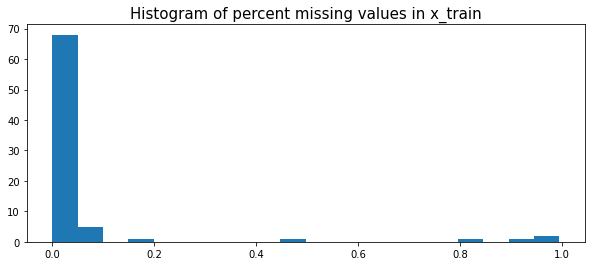

In [6]:
plt.figure(figsize=(10,4))
plt.hist(x_train.isnull().mean(), bins=20)
plt.title('Histogram of percent missing values in x_train', fontsize=15)
plt.show()

By looking at the above histogram, maybe it is a good idea, if we delete the columns which have 40% or more missing values.

In [7]:
missing_cols = x_train.columns[x_train.isnull().mean() > .4]

x_test = x_test.loc[:,~x_train.columns.isin(missing_cols)]
x_train = x_train.loc[:,~x_train.columns.isin(missing_cols)]

print('The columns with a large number of missing values are:', list(missing_cols))

The columns with a large number of missing values are: ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


## Section 3: Split Numerical and Categorical columns

We create two lists, containing the column names of categorical and numerical variables.

In [8]:
num_cols, cat_cols = [], []

for col in x_train.columns:
    if x_train[col].dtype == object:
        cat_cols.append(col)
    else:
        num_cols.append(col)

In [9]:
print('There are', len(cat_cols), 'categorical columns.')
print('There are', len(num_cols), 'numerical columns.')

There are 39 categorical columns.
There are 35 numerical columns.


## Section 4: Categorical Pipeline

First, we will impute the missing values by filling the columns with most frequent value. Then we will one-hot-encode the columns.

Let's put the two in a pipeline called `cat_pipeline`.

In [10]:
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([('imputer_mode', SimpleImputer(strategy='most_frequent')),
                         ('one_hot_encoder', OneHotEncoder(handle_unknown = "ignore"))])

## Section 5: Numerical Pipeline

This time we will impute the missing values with the mean of the columns. Then, we will apply a standard scaler on these features.

Again, let's put these transformations in a pipeline called `num_pipeline`.

In [11]:
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('imputer_mean', SimpleImputer(strategy='mean')),
                         ('scaler', StandardScaler())])

## Section 6: Merge Categorical and Numerical Pipelines

We already know what features are categorical and what features are numerical. We want to build a transformer, which runs categorical columns in the `cat_pipeline`, numerical columns in the `num_pipeline`, and finally merges them into a big dataset.

Luckily, scikit-learn's `ColumnTransformer` does this job pretty well. We name this transformation `col_transformer`.

In [12]:
from sklearn.compose import ColumnTransformer

col_transformer = ColumnTransformer(transformers=[('cat_transformer', cat_pipeline, cat_cols),
                                                  ('num_transformer', num_pipeline, num_cols)])

## Section 7: Full pipeline

Now that we have a `col_transformer` that takes the raw data as input, and spits out a imputed and processed data, we can put it into a pipeline which ends with an estimator.

Usually, xgboost is a great choice for regression tasks. So, let's build our last pipeline, which consists of the `col_transformer` and `xgb_regressor`.

In [13]:
from xgboost import XGBRegressor

xgb = XGBRegressor(max_depth=7, n_estimators=500, eta=.1, random_state=0)

full_pipeline = Pipeline([('col_transformer', col_transformer),
                          ('xgb_regressor', xgb)])

## Section 8: Cross validation

Now that we have finalized our pipeline, we can use scikit-learn's `cross_val_score` for an estimation for the errors.

Kaggle evaluates the results based on __root mean squared error__ of the log-labels. We have already computed the logarithms of the labels, and written them in `y_train`. 

Scikit-learn always wants its scorer functions to produce higher values from better models. However, this is not the case for `root_mean_squared_error`. _i.e._, better models imply lower root mean squared error. This is why scikit-learn does not have a built-in `root_mean_squared_error`, but instead, they use `neg_root_mean_squared_error` (neg means negative).

To get the actual root mean squared error, we simply multiply the result with -1.

In [14]:
from sklearn.model_selection import cross_val_score

result = cross_val_score(full_pipeline, x_train, y_train, scoring='neg_root_mean_squared_error')

print('The cross validation score is', np.mean(-result))

The cross validation score is 0.12805311983268725


## Section 9: Submission

Not we create our submission file. Note the we made our predictions using log-labels, so we need to convert them back.

In [15]:
full_pipeline.fit(x_train, y_train)

y_test_predicted = full_pipeline.predict(x_test)

submission = pd.DataFrame()
submission['Id'] = x_test_id
submission['SalePrice'] = np.exp(y_test_predicted) #converted to original prices

submission.to_csv('submission.csv', index=False)

## Section 10: Future Work

The results can further be improved if we try some of the following steps:

- Different hyperparameters for xgboost estimator (e.g. max_depth=10 instead of max_depth=7)
- Different estimators (e.g. RandomForestRegressor instead of XGBRegressor)
- We can put a feature selector (e.g. VarianceThreshold) immediately after the `col_transformer`.
- Lastly, but most importantly, we can do some actualy feature engineering. 
    - Example 1: the column `LotShape` has four values: `Reg`, `IR1`, `IR2`, and `IR3` (which stands for Regular, slightly irregular, ..., most irregular). Instad of one-hot-encoding this categorical variable, we could transform it to a binary numerical variable (1=Regular, 0=Irregular).
    - Example 2: The columns `LotFrontage`, `GrLivArea` etc. are right-skewed. A log-transformation can yield better performances.